# 模型训练
*说明：我们总共尝试了三个模型训练数据，分别为：xgboost，GBDT，GBDT+LR。其中GBDT+LR方法由于电脑配置的限制，在使用GBDT生成的特征这一阶段，模型的复杂度设置比较低，没有完全学习出样本的信息，致使再使用LR产生的结果并不好，而选用复杂的模型设置，导致生成特征比较多，导致电脑直接死机，所以后面没再尝试，如果硬件可以，可以尝试这一方法，或者尝试GBDT+PCA+LR（这一想法没来得及尝试）。xgboost做了两次尝试都没有GBDT结果好，所以最终选择了GBDT模型训练数据，结果中最好的参数设置见GBM训练那一节。在特征方面，画出特征的重要性图，有些特征对模型的贡献虽然比较小，但是如果去掉的话会影响模型的性能。*

**目录**
1. 读取训练集和测试集
2. 编码数据集
3. 优化内存
4. 展示部分测试集和训练集
5. 模型训练
6. 特征重要性图
7. 结果保存

# 读取训练集和测试集

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import metrics
# from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import pickle
# 获取当前的工作目录
pwd = os.getcwd()
# 将工作目录更改到训练集
os.chdir("处理后训练集")
# ——————————————————————————读取训练数据—————————————————————————————— #
# 航班数据
with open('colums_type.pickle','rb') as f:
    colums_types = pickle.load(f)
train_data = pd.read_table('train_data1.csv',sep=',',encoding='gb2312',dtype=colums_types)
os.chdir(pwd)
# 改回原来工作目录

# 填充缺失值
train_data['到达天气'] = train_data['到达天气'].astype('object')
train_data['到达天气']=train_data['到达天气'].fillna('0')
train_data['出发天气'] = train_data['出发天气'].astype('object')
train_data['出发天气']=train_data['出发天气'].fillna('0')
train_data['前序延误']=train_data['前序延误'].fillna(train_data['前序延误'].mean()) #均值填充
train_data['出发气温'] = train_data['出发气温'].astype('object')
train_data['出发气温']=train_data['出发气温'].fillna('一般')
train_data['到达气温'] = train_data['到达气温'].astype('object')
train_data['到达气温']=train_data['到达气温'].fillna('一般')
train_data['起飞间隔'] = train_data['起飞间隔'].fillna(train_data['起飞间隔'].mean())#均值填充
# train_data = train_data.dropna()
# 分类变量
targets = np.where(train_data['起飞延误时间']>3,1,0)

del(train_data['起飞延误时间'])

# ——————————————————————————读取测试数据—————————————————————————————— #
# 工作目录更改到测试集以读取数据
os.chdir("处理后测试集")
# 航班数据
test_data = pd.read_table('test_data1.csv',sep=',',encoding='gb2312')
# 改回工作目录
os.chdir(pwd)
train_columns = train_data.columns
test_data = test_data[train_columns]
# 填充缺失值
test_data['到达天气'] = test_data['到达天气'].astype('object')
test_data['到达天气']=test_data['到达天气'].fillna('0')
test_data['出发天气'] = test_data['出发天气'].astype('object')
test_data['出发天气']=test_data['出发天气'].fillna('0')
test_data['前序延误']=test_data['前序延误'].fillna(test_data['前序延误'].mean()) #均值填充
test_data['出发气温'] = test_data['出发气温'].astype('object')
test_data['出发气温']=test_data['出发气温'].fillna('一般')
test_data['到达气温'] = test_data['到达气温'].astype('object')
test_data['到达气温']=test_data['到达气温'].fillna('一般')
test_data['起飞间隔'] = test_data['起飞间隔'].fillna(train_data['起飞间隔'].mean()) #均值填充

# 编码数据集

In [2]:
# 对字符型数据编码
columns = ['出发机场', '到达机场', '出发天气', '到达天气','航班编号','出发气温','到达气温','航空公司']

le = preprocessing.LabelEncoder()
for col in columns :
    train_data[col] = le.fit_transform(train_data[col])
#     未见过的字符加进去
    clas = list(le.classes_)
    clas = clas + list(test_data[col])
    le.classes_ = np.array(np.unique(clas))
    
    test_data[col] = le.transform(test_data[col])

# 优化内存

In [3]:
# # 优化内存
for i in train_data.columns:
    if train_data[i].dtypes == 'int64':
        train_data[i] = pd.to_numeric(train_data[i],errors='ignore',downcast='unsigned')
        test_data[i] = pd.to_numeric(test_data[i],errors='ignore',downcast='unsigned')
    elif train_data[i].dtypes == 'float64':
        train_data[i] = pd.to_numeric(train_data[i],errors='ignore',downcast='float')
        test_data[i] = pd.to_numeric(test_data[i],errors='ignore',downcast='float')

# 展示部分测试集和训练集

In [4]:
test_data.head()

,出发机场,到达机场,航班编号,飞机编号,计划飞行时间,计划起飞时刻,航班月份,计划到达时刻,前序延误,起飞间隔,到达特情,出发特情,出发天气,出发气温,到达天气,到达气温,航空公司,航班性质
0,160,375,25554,0.0,2.333333,23,7,1,0.668666,4.503409,0,0,0,0,117,0,128,1
1,160,300,25554,0.0,6.166667,23,7,5,0.668666,4.503409,0,0,0,0,95,0,128,1
2,427,165,25450,0.0,1.416667,23,7,0,0.668666,4.503409,0,0,0,0,102,0,128,1
3,427,367,25450,0.0,3.666667,23,7,2,0.668666,4.503409,0,0,0,0,95,0,128,1
4,218,452,1393,0.0,1.833333,23,7,1,0.668666,4.503409,0,0,0,0,97,0,6,1


In [5]:
train_data.head()

,出发机场,到达机场,航班编号,飞机编号,计划飞行时间,计划起飞时刻,航班月份,计划到达时刻,前序延误,起飞间隔,到达特情,出发特情,出发天气,出发气温,到达天气,到达气温,航空公司,航班性质
0,188,222,1388,0.0,1.083333,16,4,17,0.458432,4.511399,0,0,0,0,0,0,6,0
1,188,222,1392,0.0,0.833333,17,4,18,0.458432,-0.516667,0,0,0,0,0,0,6,0
2,320,149,12602,0.0,2.250000,21,4,0,0.458432,3.483333,0,0,0,0,17,0,59,1
3,320,100,3658,0.0,2.166667,22,4,0,0.458432,-1.633333,0,0,0,0,97,0,32,1
4,136,363,10345,0.0,1.166667,22,4,23,0.458432,4.511399,0,0,0,0,0,0,44,1


# 模型训练

## GBDT训练

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
test = test_data.copy()
# 设置参数
gbdt = GradientBoostingClassifier(loss='exponential',n_estimators=300,max_depth=10,learning_rate=0.08,min_samples_leaf=500,subsample=0.8)
# 训练
gbdt.fit(train_data,targets)
# 预测结果
pre_y = gbdt.predict_proba(test)[:,1]

# 特征重要性图

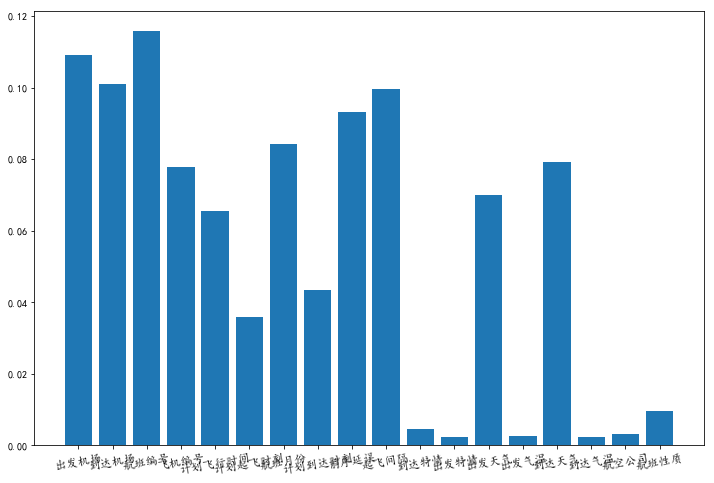

In [109]:
import matplotlib.pyplot as plt
features = list(train_data.columns)
feature_important = gbdt.feature_importances_
# feature_important = xgb.feature_importances_
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(features)),feature_important)
plt.xticks(np.arange(len(features)),features,fontsize=12,rotation=10)
plt.show()

# 结果保存

In [6]:
test_data = pd.read_table('test_data1.csv',sep=',',encoding='gb2312')
result = pd.DataFrame()
result['Flightno'] = test_data['航班编号']
result['FlightDepcode'] = test_data['出发机场']
result['FlightArrcode'] = test_data['到达机场']
result['PlannedDeptime'] = test_data['计划出发时间']
result['PlannedArrtime'] = test_data['计划到达时间']
result['prob'] = pre_y
# 将结果保存到文件，# 注意这个处理完的数据集保存在了当前文件夹下-----‘结果’
os.chdir("结果")
result.to_csv('result.csv',index=False)
os.chdir(pwd)